<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Barinia Muñoz Flores

* __Rol__: 201910521-3

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
#from metrics_classification import summary_metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [6]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Veamos si hay datos nulos

In [7]:
 digits.isna().all().unique()

array([False])

Veamos el número de filas y columnas

In [8]:
digits.shape

(1797, 65)

Ahora veamos cuanta memoria en bytes se está utilizando

In [9]:
print(digits.memory_usage(index=True,deep=True).sum())

934568


Ahora veamos algunas estadísticas de los datos

In [10]:
digits_group = digits.groupby('target')
digits_group.describe(include='all').T

target         0      1      2      3      4      5      6      7      8  \
c00 count  178.0  182.0  177.0  183.0  181.0  182.0  181.0  179.0  174.0   
    mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
c63 min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    75%      0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0   
    max      0.0   16.0   16.0    8.0    0.0    0.0    6.0    0.0    2.0   

target         9  
c00 count  180.0  
    mean     0.0  
    std      0.0  
    min      0.0  
    25%      0.0  
...          ...  
c63 min      0.0  
    25%      0.0  
    50%      0.0  
    75%      0.0  
    max      3.0  

[512 rows x 10 columns]

Veamos la distribución de los datos

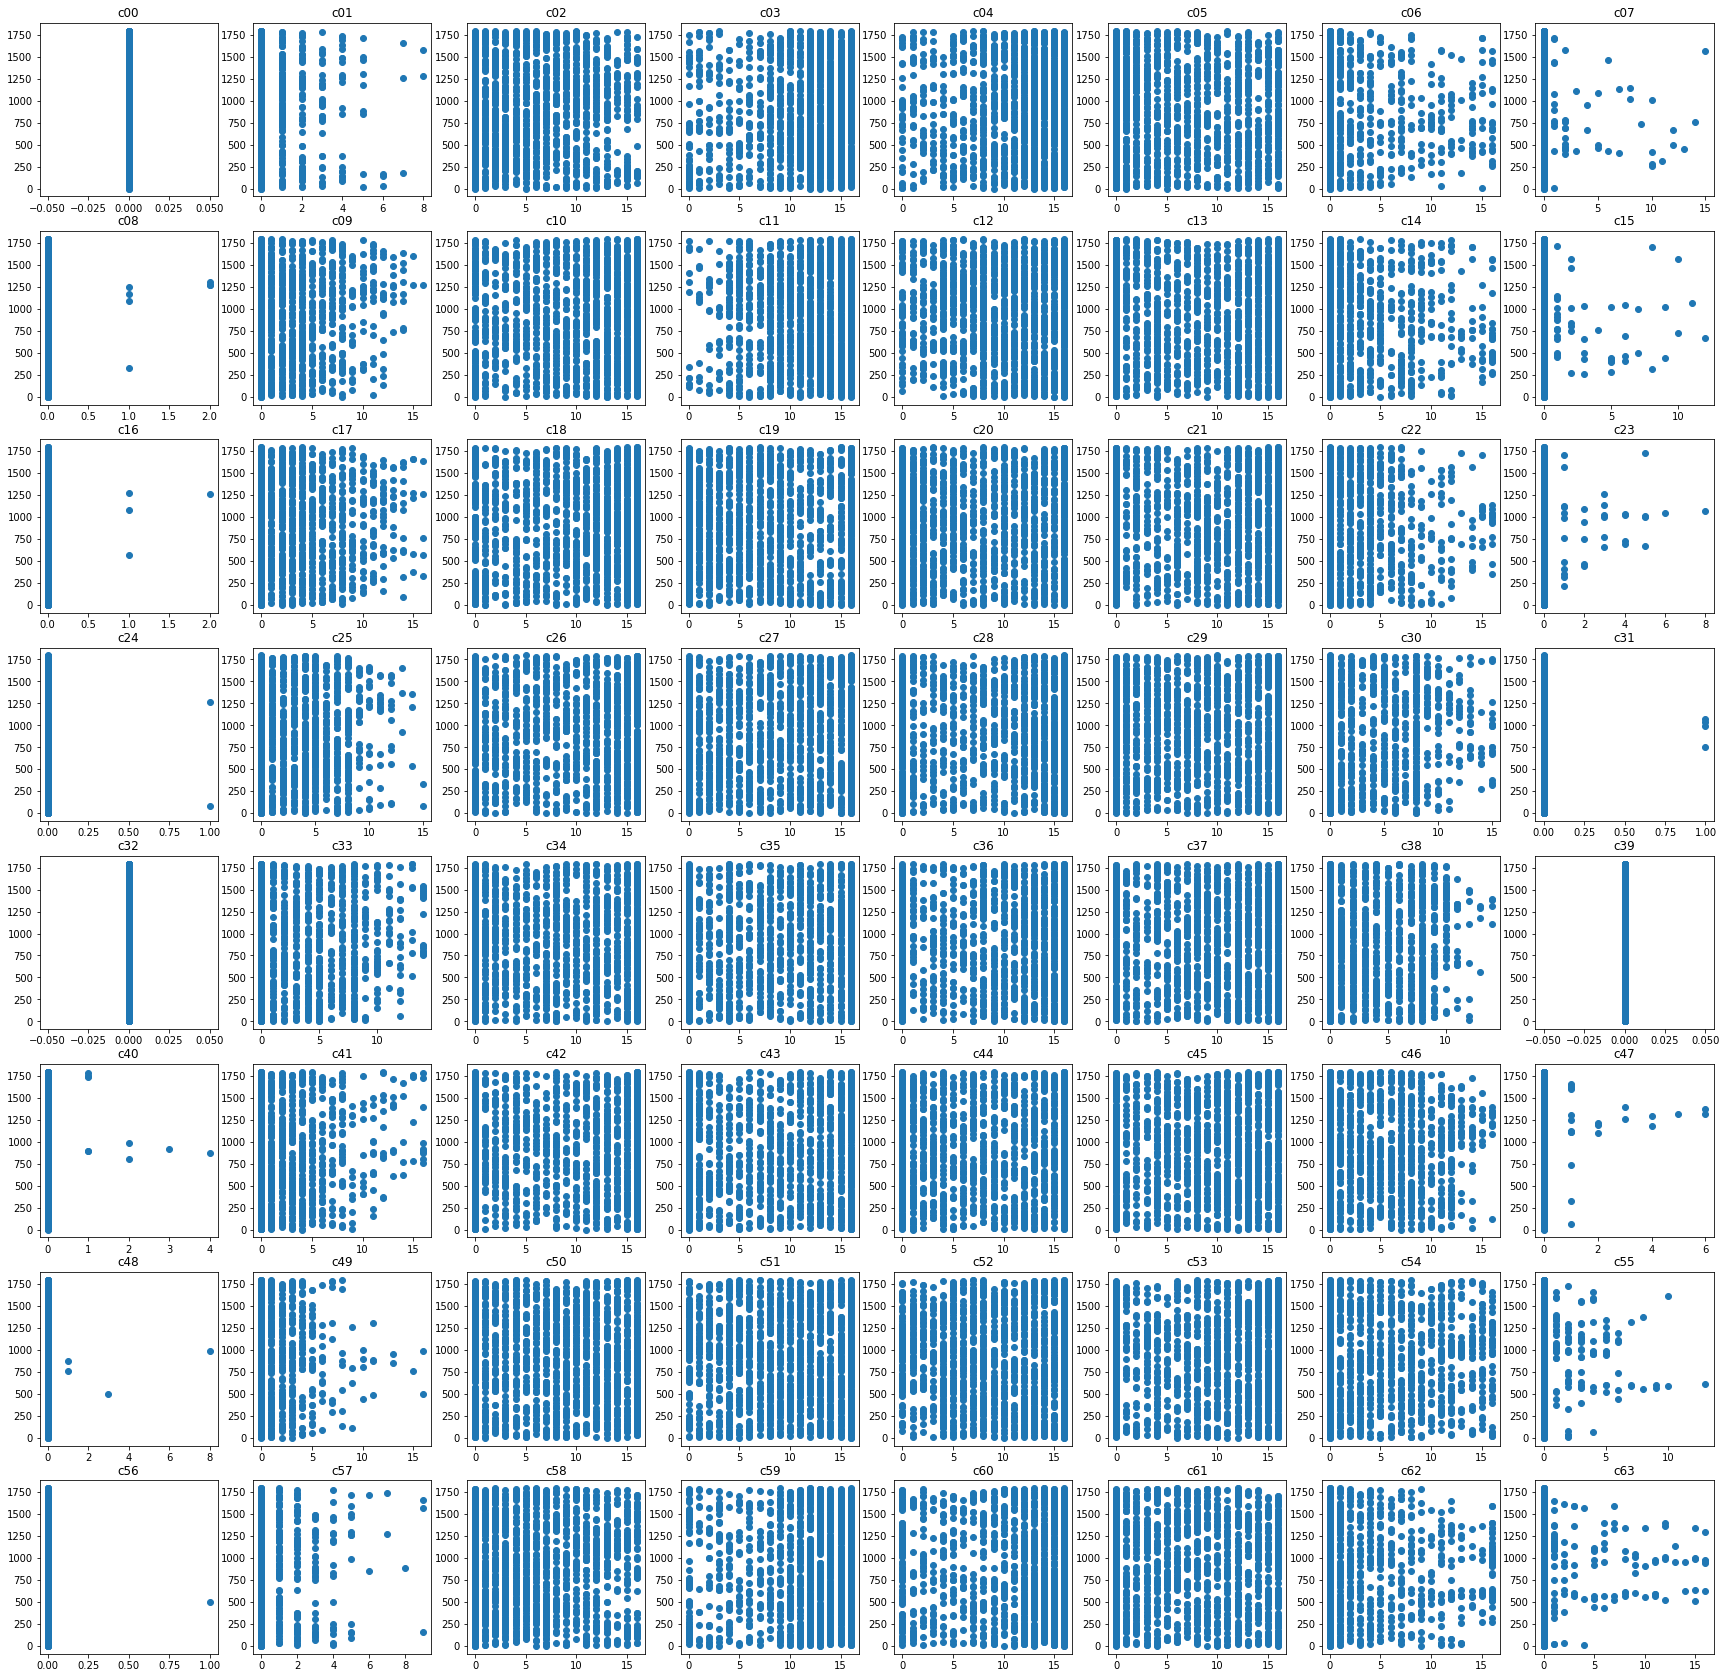

In [11]:
y = [i for i in range(len(digits))]
fig = plt.figure(figsize = (30,30))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.scatter(digits[digits.columns[i]],y)
    plt.title(digits.columns[i])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [12]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

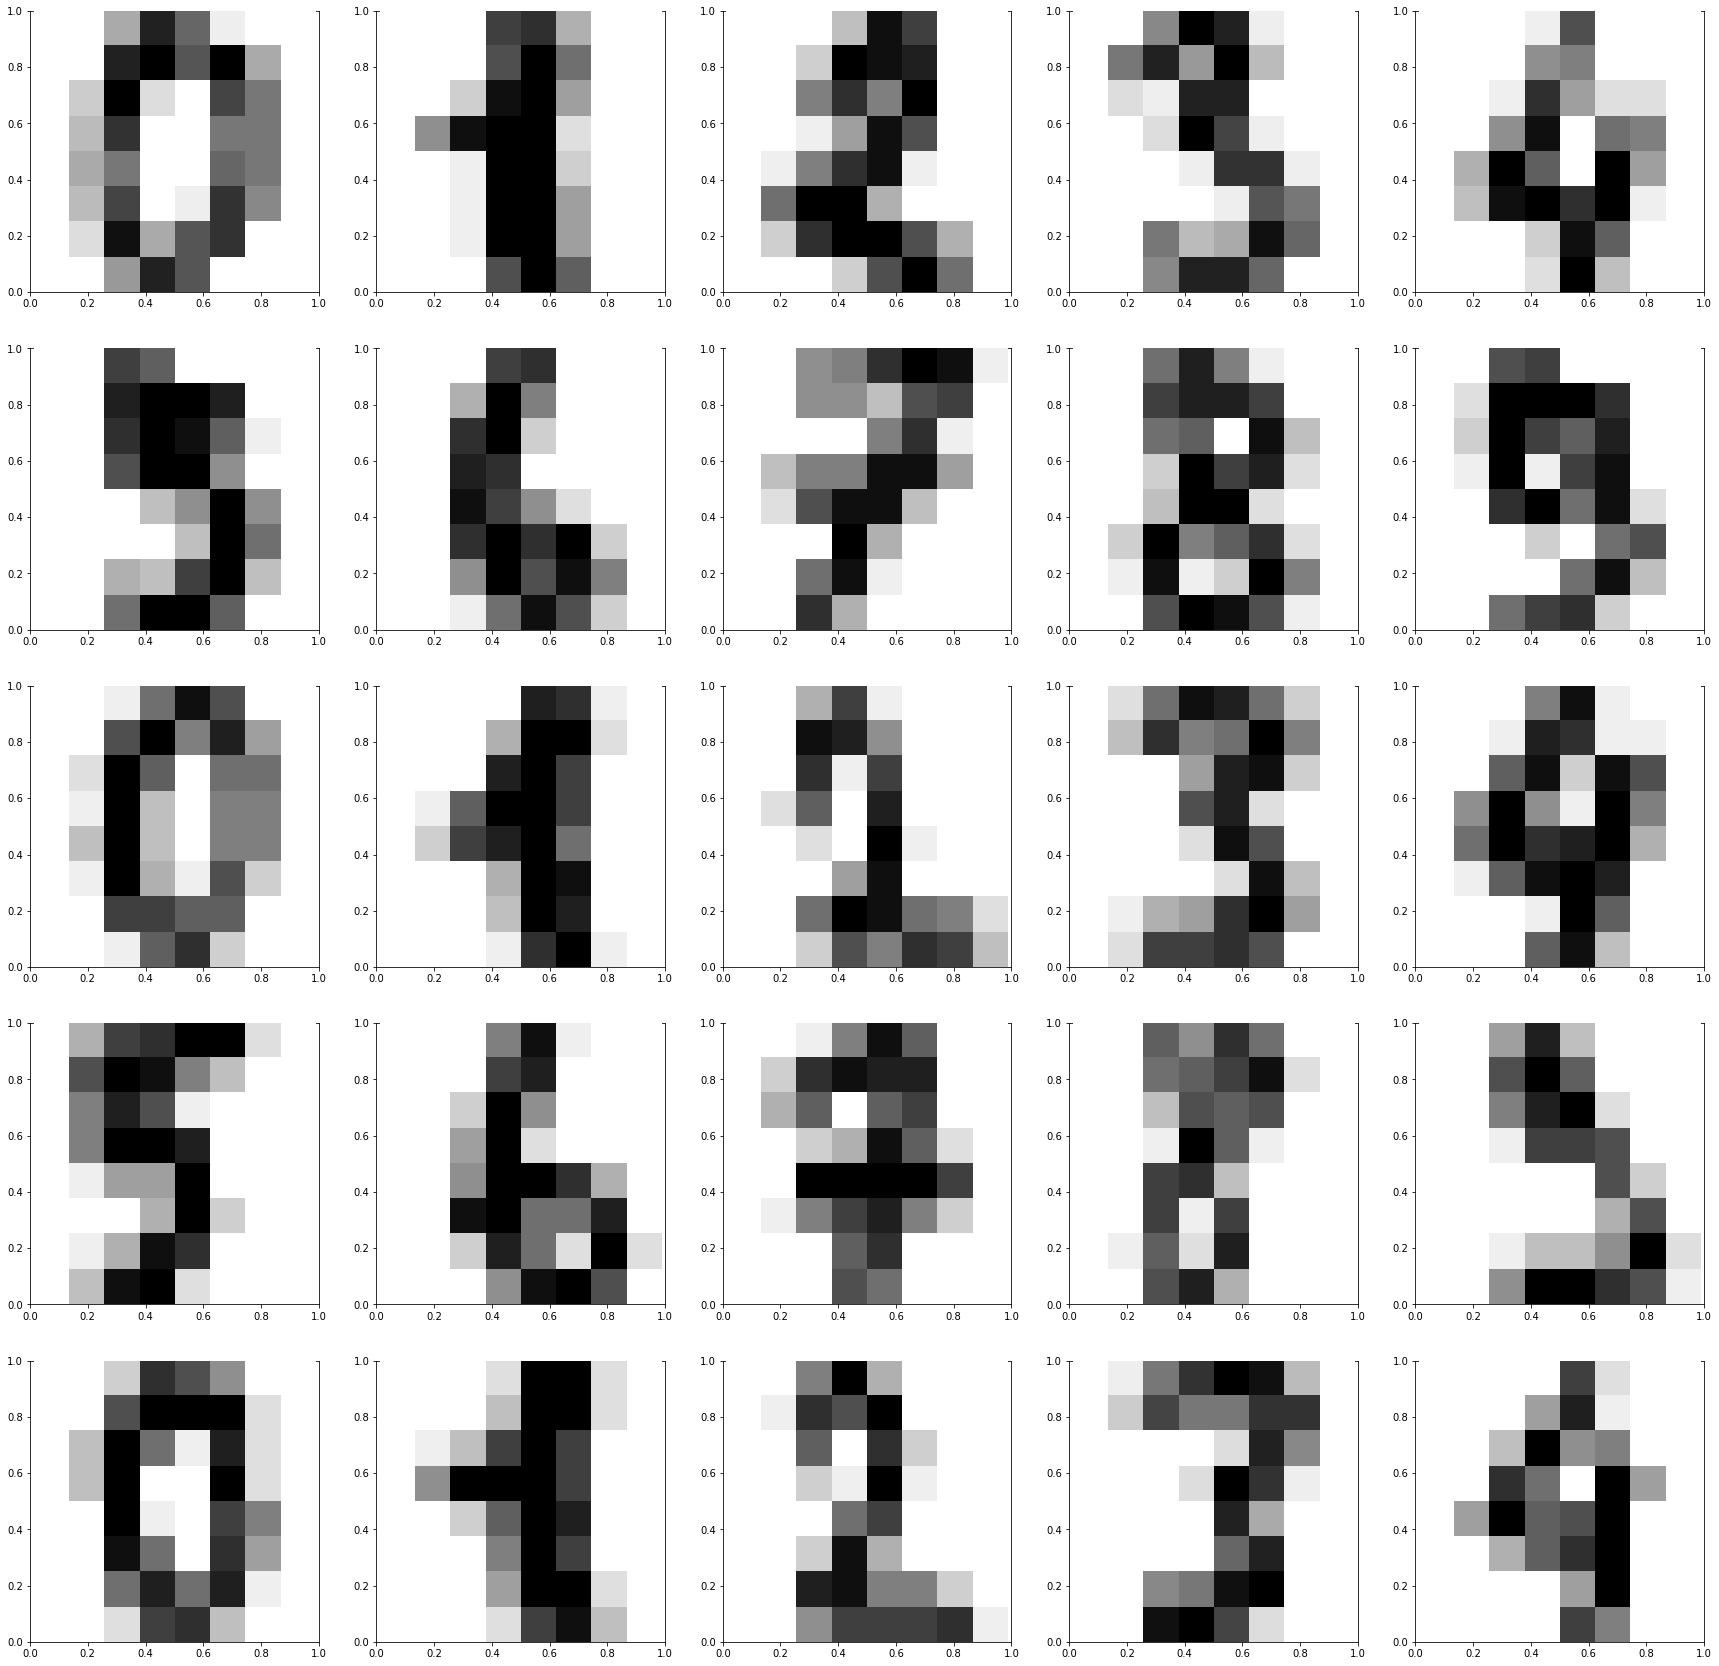

In [13]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(30, 30))
for i in range(1, nx*ny+1):
    img = digits_dict['images'][i-1]
    fig.add_subplot(nx, ny, i)
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [14]:
from google.colab import files        # Adjuntar metrics_classification.py
src = list(files.upload().values())[0]
open('metrics_classification.py','wb').write(src)
import metrics_classification

Saving metrics_classification.py to metrics_classification.py


In [15]:
from metrics_classification import summary_metrics

X = digits.drop(columns="target").values
y = digits["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1203
numero de filas test set      :  594


Modelo de regresión logística

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

#Hiperparámetros

params_logreg = {
          'penalty' : ['l1', 'l2'],
          'C' : [100, 10 , 1, 0.1, 0.01],
          'class_weight' : ['balanced', None],
          'solver' : ['liblinear'],
          }

logreg_model = LogisticRegression()

logreg_gridsearchcv = GridSearchCV(estimator = logreg_model, param_grid = params_logreg, cv = 10)

start_time = time.time()

logreg_grid_result = logreg_gridsearchcv.fit(X_train, y_train)


print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

Tiempo de ajuste del modelo: 55.34356904029846 segundos


In [17]:
print(f"Mejor resultado: {logreg_grid_result.best_score_}")
print(f"Mejores hiperparametros: {logreg_grid_result.best_params_}")

Mejor resultado: 0.9692561983471075
Mejores hiperparametros: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
y_pred = logreg_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9411,0.9402,0.9397,0.9396


In [19]:
from sklearn.metrics import confusion_matrix

print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,61,0,0,0,0,0,0,0,0,0
1,0,55,0,1,0,0,1,0,3,1
2,0,0,55,0,0,0,0,0,0,0
3,0,0,0,62,0,2,0,2,1,1
4,0,1,0,0,55,0,0,0,0,3
5,1,1,0,0,0,59,0,0,0,2
6,0,0,0,0,0,1,65,0,1,0
7,0,0,0,0,0,0,0,56,0,1
8,0,5,0,1,0,1,0,0,45,0
9,1,0,0,1,0,0,0,1,2,46


Modelo K-nearest neighbour

In [20]:
from sklearn.neighbors import KNeighborsClassifier

#Hiperparámetros
params_knn = {
          'n_neighbors' : [3, 5, 11, 19],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan'],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

knn_gridsearchcv = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

knn_grid_result = knn_gridsearchcv.fit(X_train, y_train)

print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

Tiempo de ajuste del modelo: 10.38780689239502 segundos


In [21]:
print(f"Mejor resultado: {knn_grid_result.best_score_}")
print(f"Mejores hiperparametros: {knn_grid_result.best_params_}")

Mejor resultado: 0.9866873278236916
Mejores hiperparametros: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [22]:
y_pred = knn_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9815,0.9811,0.9804,0.9805


In [23]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,61,0,0,0,0,0,0,0,0,0
1,0,61,0,0,0,0,0,0,0,0
2,0,0,55,0,0,0,0,0,0,0
3,0,0,0,65,0,0,0,1,1,1
4,0,0,0,0,56,0,0,1,1,1
5,0,0,0,0,0,62,0,0,0,1
6,0,0,0,0,0,0,67,0,0,0
7,0,0,0,0,0,0,0,57,0,0
8,0,2,0,0,0,0,0,0,50,0
9,0,0,0,0,0,0,0,1,1,49


Análisis discriminante lineal

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda = LinearDiscriminantAnalysis(solver='svd', )#Calculamos el LDA con la matriz SVD
params_lda = {
    'n_components': (0,5,1),
    'store_covariance' :(True, False),
                   }
lda_gridsearchcv = GridSearchCV(
    estimator = model_lda,
    param_grid = params_lda,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

start_time = time.time()

lda_grid_result = lda_gridsearchcv.fit(X_train, y_train)

print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

Tiempo de ajuste del modelo: 1.913727045059204 segundos


In [25]:
print(f"Mejor resultado: {lda_grid_result.best_score_}")
print(f"Mejores hiperparametros: {lda_grid_result.best_params_}")

Mejor resultado: 0.9509474412171507
Mejores hiperparametros: {'n_components': 0, 'store_covariance': True}


In [26]:
y_pred = lda_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9428,0.9405,0.9413,0.9405


Se puede ver que el modelo K-nearest neighbour se ajusta mejor a los datos del problema en comparacion a los otros dos estudiados, y es mas rápido que el primer modelo estudiado, pero más lento que el último.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

Cross Validation

In [27]:
from sklearn.model_selection import cross_val_score

precision = cross_val_score(estimator=knn_gridsearchcv,
                            X=X_train,
                            y=y_train,
                            cv=10)

precision = [round(x,2) for x in precision]
print(f'Precisiones: {precision} ')


print(f"El valor promedio es {np.mean(precision)} y la desviacion estandar es {round(np.std(precision),3)}")


Precisiones: [0.98, 1.0, 0.99, 0.98, 0.99, 0.98, 0.98, 0.98, 0.99, 0.99] 
El valor promedio es 0.986 y la desviacion estandar es 0.007


Curva de Validación

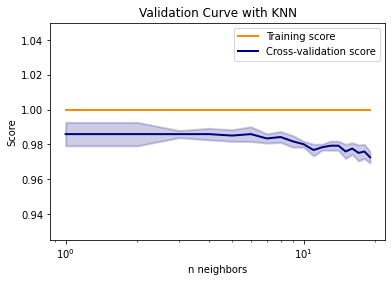

In [28]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1,20,1)

# Usamos los mejores hiperparametros 
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(
        weights = 'distance',
        metric = 'euclidean',
        algorithm = 'auto',
        n_neighbors =  3

        ), 
    X_train, 
    y_train, 
    param_name="n_neighbors", 
    param_range=param_range,
    scoring="accuracy", 
    n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.title("Validation Curve with KNN")
plt.xlabel(r"n neighbors")
plt.ylabel("Score")
plt.ylim(0.925, 1.05)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

Curva AUC-ROC

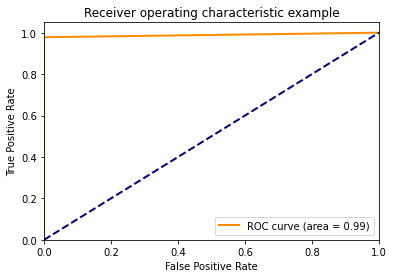

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = KNeighborsClassifier(
        weights = 'distance',
        metric = 'euclidean',
        algorithm = 'auto',
        n_neighbors =  3
)
y_score = classifier.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [30]:
X = pd.DataFrame(digits.drop(columns="target").drop(['c00','c32','c39'], axis=1) )
y = digits["target"]

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k = 20  # número de atributos a seleccionar
columnas = list(X.columns.values)
selected_predictors = SelectKBest(f_classif, k=k).fit(X, y)
support_predictors = selected_predictors.get_support()
atributes = [columnas[i] for i in list(support_predictors.nonzero()[0])]
print(atributes)

['c02', 'c10', 'c13', 'c20', 'c21', 'c26', 'c28', 'c30', 'c33', 'c34', 'c36', 'c38', 'c42', 'c43', 'c44', 'c46', 'c54', 'c58', 'c60', 'c61']


In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(X)
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X)
selected_predictors = SelectKBest(f_classif, k=k).fit(X, y)

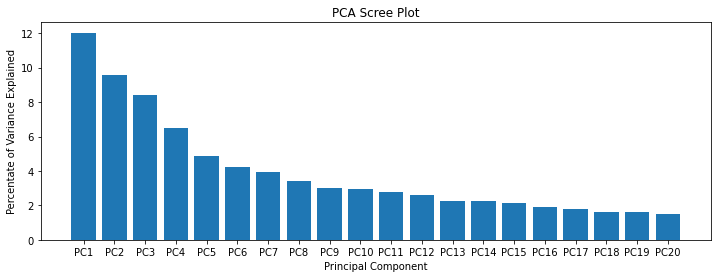

In [33]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns=[]
for i in range(1, 21):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(f'PC{i}')
    columns

plt.figure(figsize=(12,4))
plt.bar(x= range(1,21), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

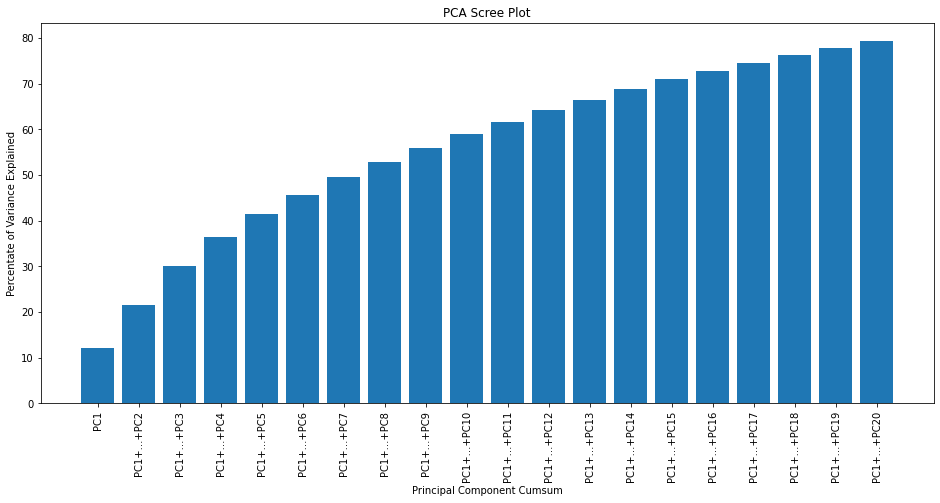

In [34]:
percent_variance_cum = np.cumsum(percent_variance)
columns = []
for i in range(1, 21):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(columns[0] + f'+...+PC{i}')
columns

plt.figure(figsize=(16,7))
plt.bar(x= range(1,21), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xticks(x= range(1,21), rotation='vertical')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

In [35]:
X_k = pd.DataFrame(X,columns=columnas)[atributes]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_k, y, test_size=0.33, random_state=2)

precision = cross_val_score(estimator=knn_gridsearchcv,X=X_train2,y=y_train2,cv=10)

precision = [round(x,2) for x in precision]
print(f'Precisiones: {precision} ')
print(f'La precision promedio es {round(np.mean(precision),3)}, y su desviacion estandar es {round(np.std(precision),3)}')

Precisiones: [0.95, 0.99, 0.98, 0.95, 0.97, 0.97, 0.94, 0.94, 0.98, 0.99] 
La precision promedio es 0.966, y su desviacion estandar es 0.019


In [36]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(principalComponents, y, test_size=0.33, random_state=2)

classifier = KNeighborsClassifier(weights = 'distance',metric = 'euclidean', n_neighbors = 3)

precision = cross_val_score(estimator=knn_gridsearchcv,X=X_train3,y=y_train3,cv=10)

precision = [round(x,2) for x in precision]
print(f'Precisiones: {precision} ')
print(f'La precision promedio es {round(np.mean(precision),3)}, y su desviacion estandar es {round(np.std(precision),3)}')

Precisiones: [0.98, 0.98, 0.97, 0.94, 0.98, 0.98, 0.98, 0.96, 0.98, 0.95] 
La precision promedio es 0.97, y su desviacion estandar es 0.014


In [37]:
params_knn = {
          'n_neighbors' : [3, 5, 11, 19],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan'],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

knn_gridsearchcv = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

knn_grid_result = knn_gridsearchcv.fit(X_train2, y_train2)

print('KNN with GridSearch and atributes')
print(f"{time.time() - start_time} segundos" )

#Método K-Nearest Neighbours extrayendo atributos y usando PCA

start_time = time.time()

knn_grid_result_2 = knn_gridsearchcv.fit(X_train3, y_train3)

print('')
print('KNN with PCA')
print(f"{time.time() - start_time} segundos" )

KNN with GridSearch and atributes
6.04147744178772 segundos

KNN with PCA
4.9492621421813965 segundos


### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [38]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

<ipython-input-38-927e9ab12ef8>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask = (y_pred == y_test)


IndexError: ignored

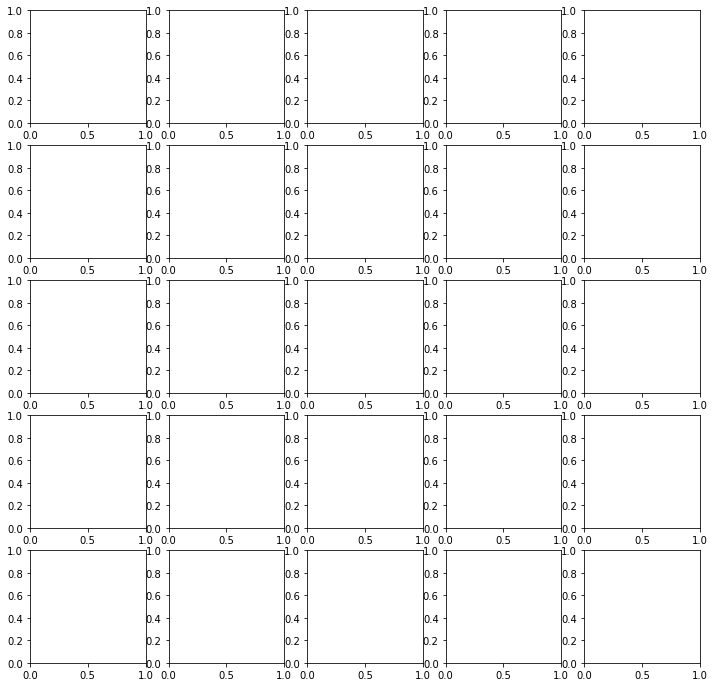

In [39]:
mostar_resultados(digits,KNeighborsClassifier(),nx=5, ny=5,label = "correctos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

Analisis Exploratorio

In [40]:
import seaborn as sns 

import warnings
warnings.simplefilter("ignore")

In [41]:
# read data
housing = pd.read_csv('sample_data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Veamos el número de filas y columnas

In [42]:
housing.shape

(20640, 10)

Ahora veamos cuanta memoria en bytes se está utilizando

In [43]:
housing.memory_usage(index=True,deep=True).sum()

2829148

Primero convertimos la columna ocean_proximity en datos numericos para poder utilizarlos (Parte del preprocesamiento).

In [44]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [45]:
housing['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],[0,1,2,3,4],inplace=True)
housing["ocean_proximity"].unique()

array([0, 1, 2, 3, 4])

Estadística descriptiva

Vemos las estadísticas de las columnas

In [46]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,1.464729
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,0.854226
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,1.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,2.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


Vemos la correlación entre las columnas

In [60]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069120,0.099773,0.055310,-0.015176,-0.045967,0.180381
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066484,-0.108785,-0.071035,-0.079809,-0.144160,-0.067586
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.319026,-0.296244,-0.302916,-0.119034,0.105623,-0.204882
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927058,0.857126,0.918484,0.198050,0.134153,0.014818
total_bedrooms,0.069120,-0.066484,-0.319026,0.927058,1.000000,0.873535,0.974366,-0.007617,0.049457,0.004076
population,0.099773,-0.108785,-0.296244,0.857126,0.873535,1.000000,0.907222,0.004834,-0.024650,-0.008511
households,0.055310,-0.071035,-0.302916,0.918484,0.974366,0.907222,1.000000,0.013033,0.065843,-0.016911
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007617,0.004834,0.013033,1.000000,0.688075,-0.129135
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049457,-0.024650,0.065843,0.688075,1.000000,-0.210600
ocean_proximity,0.180381,-0.067586,-0.204882,0.014818,0.004076,-0.008511,-0.016911,-0.129135,-0.210600,1.000000


Veamos si hay datos nulos

In [61]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Preprocesamiento

A continuación los datos nulos de la columna total_bedrooms los reemplazaremos por la mediana, y no por la media por que no es tan representativa debido a que los datos aislados son muy grandes (ver en la visualización descriptiva).

In [47]:
housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(),inplace=True)

In [48]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Visualización descriptiva

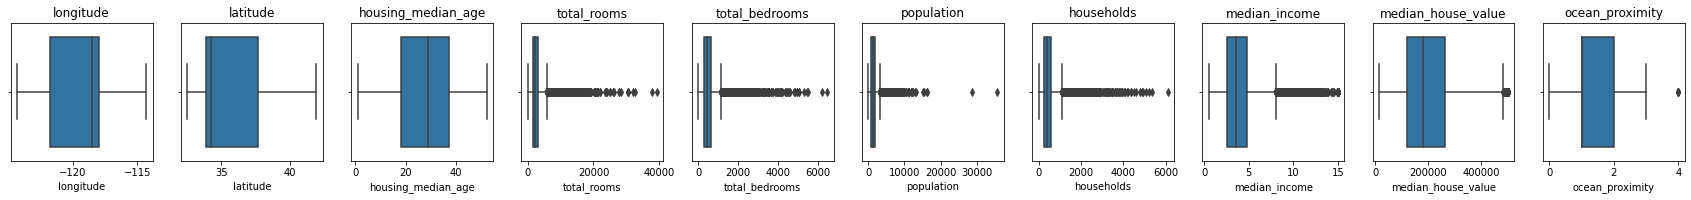

In [49]:
fig = plt.figure(figsize = (30,30))
for i in range(10):
    plt.subplot(10,10,i+1)
    sns.boxplot(housing[housing.columns[i]])
    plt.title(housing.columns[i])

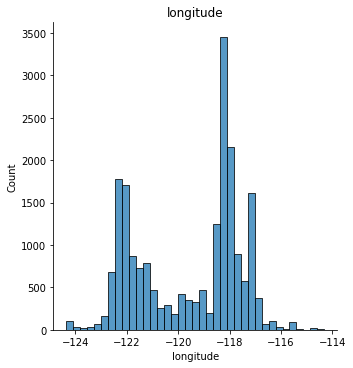

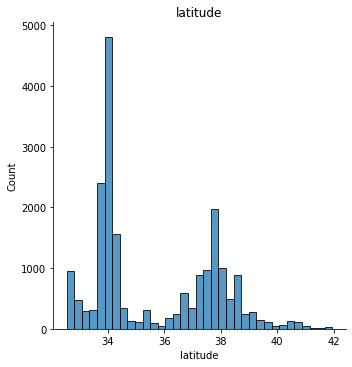

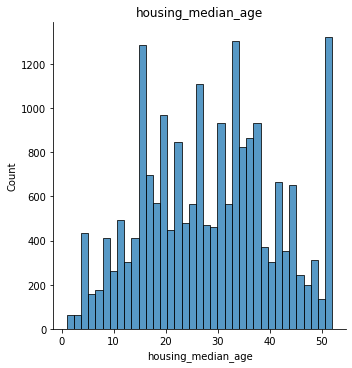

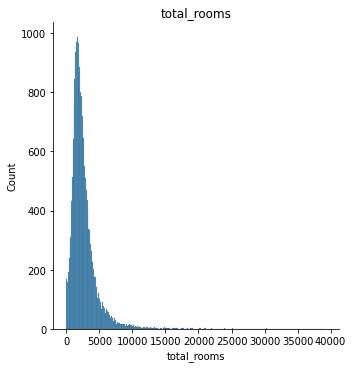

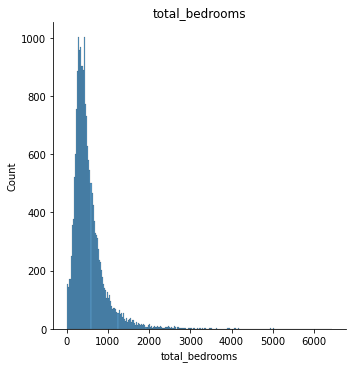

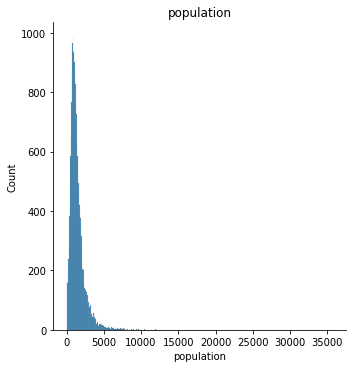

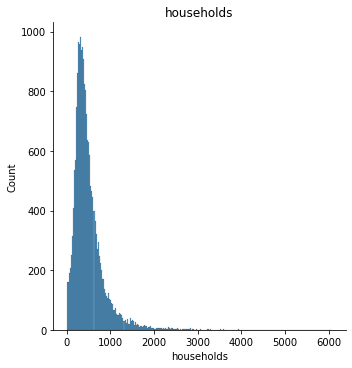

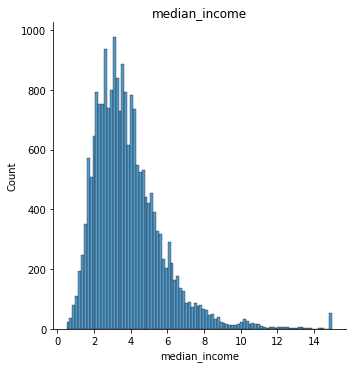

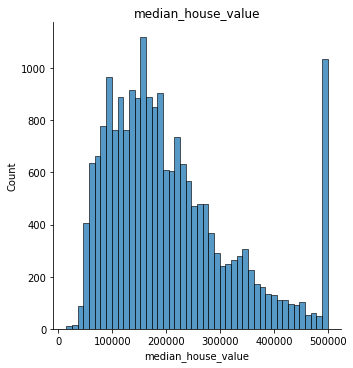

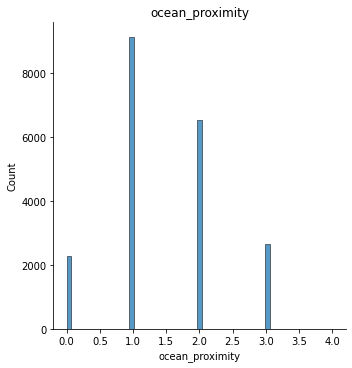

In [50]:
for i in range(10):
    sns.displot(housing[housing.columns[i]])
    plt.title(housing.columns[i])


Construcción y selección de los modelos

Creamos el conjunto de entrenamiento y de testeo

In [51]:
X = housing.drop(columns="median_house_value").values
y = housing["median_house_value"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  20640
numero de filas train set     :  13828
numero de filas test set      :  6812


Modelo K-nearest neighbour

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time

#Hiperparámetros
params_knn = {
          'n_neighbors' : [3, 5, 11, 19],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan'],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

knn_gridsearchcv = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

knn_grid_result = knn_gridsearchcv.fit(X_train, y_train)

print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

Tiempo de ajuste del modelo: 90.4683587551117 segundos


In [53]:
print(f"Mejor resultado: {knn_grid_result.best_score_}")
print(f"Mejores hiperparametros: {knn_grid_result.best_params_}")

Mejor resultado: 0.03384439749574374
Mejores hiperparametros: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


In [54]:
y_pred = knn_gridsearchcv.predict(X_test) 
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.0377,0.0006,0.0002,0.0003


In [55]:
from sklearn.metrics import confusion_matrix
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9,...,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2899,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,4


Análisis discriminante lineal

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda = LinearDiscriminantAnalysis(solver='svd', )#Calculamos el LDA con la matriz SVD
params_lda = {
    'n_components': (0,5,1),
    'store_covariance' :(True, False),
                   }
lda_gridsearchcv = GridSearchCV(
    estimator = model_lda,
    param_grid = params_lda,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

start_time = time.time()

lda_grid_result = lda_gridsearchcv.fit(X_train, y_train)

print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

Tiempo de ajuste del modelo: 11.289433479309082 segundos


In [57]:
print(f"Mejor resultado: {lda_grid_result.best_score_}")
print(f"Mejores hiperparametros: {lda_grid_result.best_params_}")

Mejor resultado: 0.03485676628761282
Mejores hiperparametros: {'n_components': 0, 'store_covariance': True}


In [58]:
y_pred = lda_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.0348,0.0009,0.0002,0.0003


Modelo Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)

params_clf = {
    'n_estimators': [3, 10, 30],
     'max_features': [2, 4, 6, 8],
}

clf_gridsearchcv = GridSearchCV(estimator = clf, param_grid = params_clf, cv = 10)

start_time = time.time()

clf_grid_result = clf_gridsearchcv.fit(X_train, y_train)

print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")

KeyboardInterrupt: ignored

Modelo de regresion logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

#Hiperparámetros

params_logreg = {
          'penalty' : ['l1', 'l2'],
          'C' : [100, 10 , 1, 0.1, 0.01],
          'class_weight' : ['balanced', None],
          'solver' : ['liblinear'],
          }

logreg_model = LogisticRegression()

logreg_gridsearchcv = GridSearchCV(estimator = logreg_model, param_grid = params_logreg, cv = 10)

start_time = time.time()

logreg_grid_result = logreg_gridsearchcv.fit(X_train, y_train)


print(f"Tiempo de ajuste del modelo: {time.time() - start_time} segundos")